## Nephropathy
----------------------------------

### 1. Import packages

In [ ]:
#!conda install -c https://conda.anaconda.org/plotly plotly -y
#!pip install pydot
#!pip install graphviz
#!conda install -c anaconda py-xgboost -y
#!pip install shap
#!pip install dill
#pip install matplotlib
#pip install seaborn
#pip install missingpy
#!pip3 install pickle5
#pip install statannot

In [1]:
import pandas as pd
import sqlite3 as sql
import numpy as np
from IPython.display import HTML
from datetime import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # set plot style
from collections import Counter
import scipy as sp
import sklearn as sk
import sys
import plotly.express as px
import pydot
import pickle
import time
import xgboost as xgb
import shap
import dill
import gc
import subprocess
!pip3 install pickle5
import pickle5 as pickle
import sklearn.metrics as metrics
from scipy.stats import ranksums, ttest_ind
from statsmodels.stats.weightstats import ztest
import pylab 
import scipy.stats as stats
from scipy.stats import chi2_contingency
from matplotlib import rc
from cycler import cycler
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from statannot import add_stat_annotation

In [2]:
import os
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

from collections import defaultdict

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import time

### 2. Removing pts w/ comp diff=NaN from Output

In [8]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/comps_over1mo_df.pkl', 'rb') as handle:
    comps_over1mo_df = pickle.load(handle) 

In [9]:
#1mo
renal_time = comps_over1mo_df.KIDNEY_diff.copy()
renal_time_drop=renal_time.replace(np.nan, 'Drop', inplace=False)
renal_index = renal_time_drop [renal_time_drop == 'Drop'].index
print("Total Length: ", renal_time_drop.shape)
print("Number to be dropped: ", renal_time_drop[renal_time_drop == 'Drop'].shape)
# dropping the NaNs from our OUTput data
renal_time_drop.drop(renal_index, inplace=True)
renal_time_final = renal_time_drop.astype('float64')
print('Output dataset size:', renal_time_final.shape)

Total Length:  (30854,)
Number to be dropped:  (18979,)
Output dataset size: (11875,)


### 3. Two way drop from input and output

In [10]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/phen_demos_vit_soc_lab.pkl', 'rb') as handle:
    phen_demos_vit_soc_lab = pickle.load(handle)

In [11]:
def drop_opth_list(output_df,input_df):
    extra_list=list(set(input_df.index.tolist())-set(output_df.index.tolist()))
    input_df_new=input_df.drop(extra_list)
    extra_list_rev=list(set(output_df.index.tolist())-set(input_df_new.index.tolist()))
    output_df_new=output_df.drop(extra_list_rev)
    print('length of input_df:', len(input_df))
    print('length of opth_df:', len(output_df))
    print('length of # to drop from  input:',len(extra_list))
    print('length of # to drop from  opth:',len(extra_list_rev))
    print('length of input_df after dropping',len(input_df_new))
    print('length of opth_df after dropping',len(output_df_new))
    print('Indexes equal?', np.all(input_df_new.index == output_df_new.index))
    return output_df_new, input_df_new

In [12]:
phen_demos_vit_soc_lab.shape

(15987, 1824)

In [13]:
renal_time_final.shape

(11875,)

In [14]:
renal_final, all_inputs=drop_opth_list(renal_time_final, phen_demos_vit_soc_lab)

length of input_df: 15987
length of opth_df: 11875
length of # to drop from  input: 10379
length of # to drop from  opth: 6267
length of input_df after dropping 5608
length of opth_df after dropping 5608
Indexes equal? True


### 4. Make output diff times categorical using median as cut-off

In [15]:
renal_final.median()

3.0664558478271284

In [16]:
renal_final.max()

15.480126217513023

<Figure size 864x576 with 0 Axes>

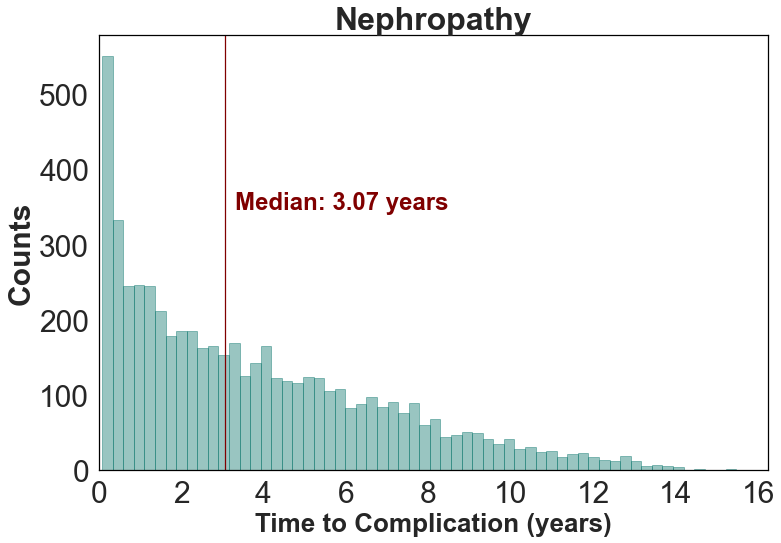

In [17]:
plt.figure(figsize=(12,8))
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
plt.figure(figsize=(12,8))
h = plt.hist(renal_final, edgecolor='#007066', 
             bins=60, alpha=0.4,
             color='#007066')
h = plt.axvline(renal_final.median(), color='maroon', linestyle='solid', linewidth=1.25)
min_ylim, max_ylim = plt.ylim()
plt.text(renal_final.median()*1.08, max_ylim*0.6, 
         'Median: {:.2f} years'.format(renal_final.median()),
         fontsize=24, fontweight=600, color='maroon')
plt.xlim(left=0.0)
plt.xlabel('Time to Complication (years)', fontsize=26, fontweight=600)
plt.ylabel('Counts', fontsize=30, fontweight=600)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Nephropathy", fontsize=32, fontweight=600)
plt.savefig(r'/Users/amomenzadeh/Desktop/DM_figures/renal_hist.svg', format='svg')
plt.show()

In [18]:
#assign 0 if opth complication occurred > renal diff median 
#assign 1 if opth complication occurred < renal diff median 
renal_final_clf = renal_final.copy()
renal_final_clf = pd.Series(np.where((renal_final_clf > renal_final.median()), 0, renal_final_clf), 
                            index=renal_final_clf.index)
renal_final_clf = pd.Series(np.where((renal_final_clf > 0), 1, renal_final_clf), 
                            index=renal_final_clf.index)

In [19]:
num_negs = renal_final_clf.value_counts()[0]
num_pos = renal_final_clf.value_counts()[1]
neg_prop = num_negs/(num_negs + num_pos)
print(str(round(neg_prop*100,2)), '% negative', sep='')
print(str(100-round(neg_prop*100,2)), '% positive', sep='')

49.98% negative
50.02% positive


In [20]:
renal_final_clf.shape

(5608,)

In [16]:
with open(r'./pickles/renal_final_clf.pkl', 'wb') as handle:
    pickle.dump(renal_final_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 5. Final Inputs

In [17]:
renal_phen=all_inputs.iloc[:,:-103]
renal_phen.columns

Index(['ASCVD', 'Abdominal aortic aneurysm', 'Abdominal hernia',
       'Abdominal pain',
       'Abnormal Papanicolaou smear of cervix and cervical HPV',
       'Abnormal arterial blood gases', 'Abnormal chest sounds',
       'Abnormal coagulation profile',
       'Abnormal electrocardiogram [ECG] [EKG]',
       'Abnormal findings examination of lungs',
       ...
       'Vitamin B-complex deficiencies', 'Vitamin D deficiency',
       'Vitamin deficiency', 'Vitiligo', 'Voice disturbance',
       'Von willebrand's disease', 'Wegener's granulomatosis', 'Wheezing',
       'severe protein-calorie malnutrition', 'stress incontinence, female'],
      dtype='object', length=1721)

In [18]:
renal_all=all_inputs.drop(['duration_diab','vital_status_Alive','vital_status_Deceased'],axis=1)

In [19]:
renal_demos_norm=renal_all.iloc[:,-100:-70]
renal_demos_norm.columns

Index(['age_at_diab', 'sex_Female', 'sex_Male', 'marital_status_Divorced',
       'marital_status_Legally Separated', 'marital_status_Married',
       'marital_status_Patient Refused', 'marital_status_Significant Other',
       'marital_status_Single', 'marital_status_Unknown',
       'marital_status_Widowed', 'employment_status_Disabled',
       'employment_status_Full Time', 'employment_status_Not Employed',
       'employment_status_On Active Military Duty',
       'employment_status_Part Time', 'employment_status_Patient Refused',
       'employment_status_Retired', 'employment_status_Self Employed',
       'employment_status_Student - Full Time',
       'employment_status_Student - Part Time', 'employment_status_Unknown',
       'race_American Indian or Alaska Native', 'race_Asian',
       'race_Black or African American', 'race_Multiracial',
       'race_Native Hawaiian or Other Pacific Islander', 'race_Other',
       'race_Unknown', 'race_White or Caucasian'],
      dtype='objec

In [21]:
renal_vitals_norm=renal_all.iloc[:,-70:-64]
renal_vitals_norm.columns

Index(['bmi', 'bp_diastolic', 'bp_systolic', 'pulse', 'temperature',
       'respiration'],
      dtype='object')

In [22]:
renal_social_norm=renal_all.iloc[:,-64:-35]
renal_social_norm.columns

Index(['alcohol_use_name_Never', 'alcohol_use_name_No',
       'alcohol_use_name_Not Asked', 'alcohol_use_name_Not Currently',
       'alcohol_use_name_Yes', 'ill_drug_user_name_Never',
       'ill_drug_user_name_No', 'ill_drug_user_name_Not Asked',
       'ill_drug_user_name_Not Currently', 'ill_drug_user_name_Yes',
       'tobacco_user_name_Never', 'tobacco_user_name_Not Asked',
       'tobacco_user_name_Passive', 'tobacco_user_name_Quit',
       'tobacco_user_name_Yes', 'cigarettes_yn_N', 'cigarettes_yn_Y',
       'pipes_yn_N', 'pipes_yn_Y', 'cigars_yn_N', 'cigars_yn_Y', 'snuff_yn_N',
       'snuff_yn_Y', 'chew_yn_N', 'chew_yn_Y',
       'smokeless_tob_use_name_Current User',
       'smokeless_tob_use_name_Former User',
       'smokeless_tob_use_name_Never Used', 'smokeless_tob_use_name_Unknown'],
      dtype='object')

In [23]:
renal_labs_norm=renal_all.iloc[:,-35:]
renal_labs_norm.columns

Index(['PLATELET COUNT', 'AST/SGOT', 'CALCIUM', 'GLUCOSE', 'BICARBONATE',
       'CHLORIDE', 'POTASSIUM', 'HEMATOCRIT', 'WHITE BLOOD CELL COUNT',
       'CREATININE', 'TOTAL PROTEIN', 'ALBUMIN', 'BLOOD UREA NITROGEN',
       'ANION GAP', 'EGFR', 'EGFR FOR AFRICAN AMERICANS', 'SODIUM',
       'BILIRUBIN TOTAL', 'ALKALINE PHOSPHATASE', 'ALT/SGPT', 'HEMOGLOBIN',
       'RED BLOOD CELL COUNT', 'MEAN CORPUSCULAR HGB',
       'MEAN CORPUSCULAR VOLUME', 'MEAN PLATELET VOLUME',
       'RED CELL DISTRIBUTION WIDTH', 'MEAN CORPUSCULAR HGB CONCENTRN',
       'MONOCYTE PERCENT', 'NEUTROPHIL PERCENT', 'EOSINOPHIL PERCENT',
       'LYMPH PERCENT', 'NEUTROPHIL ABSOLUTE', 'LYMPHOCYTE ABSOLUTE',
       'MONOCYTE ABSOLUTE', 'EOSINOPHIL ABSOLUTE'],
      dtype='object')

In [ ]:
with open(r'./pickles/renal_all.pkl', 'wb') as handle:
    pickle.dump(renal_all, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/renal_phen.pkl', 'wb') as handle:
    pickle.dump(renal_phen, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/renal_demos_norm.pkl', 'wb') as handle:
    pickle.dump(renal_demos_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/renal_vitals_norm.pkl', 'wb') as handle:
    pickle.dump(renal_vitals_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/renal_social_norm.pkl', 'wb') as handle:
    pickle.dump(renal_social_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(r'./pickles/renal_labs_norm.pkl', 'wb') as handle:
    pickle.dump(renal_labs_norm, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 6. Make Table 1

In [8]:
with open(r'./pickles/phen_prediab_bin.pkl', 'rb') as handle:
    phen_prediab_bin = pickle.load(handle)
with open(r'./pickles/social_df.pkl', 'rb') as handle:
    social_df = pickle.load(handle)
with open(r'./pickles/vitals_df.pkl', 'rb') as handle:
    vitals_df = pickle.load(handle)
with open(r'./pickles/imp_labs.pkl', 'rb') as handle:
    imp_labs = pickle.load(handle)
with open(r'./pickles/renal_final_clf.pkl', 'rb') as handle:
    renal_final_clf = pickle.load(handle)

In [13]:
demos_all = pd.read_csv(r'/Users/amomenzadeh/Desktop/DM_csv/demos_all.csv',low_memory=False)

In [14]:
demos_R = pd.read_csv(r'/Users/amomenzadeh/Desktop/DM_csv/demos_from_R.csv',low_memory=False)

In [15]:
demos_R['patient_num'] = demos_all['patient_num'].values

In [16]:
demos_R=demos_R.set_index('patient_num')

In [17]:
renal_df=renal_final_clf.to_frame(name='class')
renal_df.shape

(5608, 1)

In [18]:
all_ren=demos_R.merge(renal_df,left_index=True, right_index=True)
all_ren.shape

(5608, 8)

In [19]:
all_ren=all_ren.merge(imp_labs,left_index=True, right_index=True)
all_ren.shape

(5608, 43)

In [20]:
all_ren=all_ren.merge(vitals_df,left_index=True, right_index=True)
all_ren.shape

(5608, 49)

In [21]:
all_ren=all_ren.merge(social_df,left_index=True, right_index=True)
all_ren.shape

(5608, 58)

In [22]:
all_ren=all_ren.merge(phen_prediab_bin,left_index=True, right_index=True)
all_ren.shape

(5608, 1779)

In [23]:
all_ren.shape

(5608, 1779)

In [25]:
i_o_fast=all_ren.loc[all_ren['class'] == 1]

In [26]:
i_o_slow=all_ren.loc[all_ren['class'] == 0]

In [27]:
print("\n--Median Slow---\n")
print(i_o_slow[['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']].median())
print("\n---Median Fast---\n")
print(i_o_fast[['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']].median())


--Median Slow---

age_at_diab       58.651444
duration_diab     10.268793
GLUCOSE          163.000000
CREATININE         0.890000
bmi               33.780800
EGFR              60.000000
dtype: float64

---Median Fast---

age_at_diab       61.983477
duration_diab      5.666371
GLUCOSE          155.000000
CREATININE         0.920000
bmi               32.870000
EGFR              60.000000
dtype: float64


In [28]:
print("\n--IQR Slow---\n")
print(i_o_slow[['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']].describe())
print("\n--IQR Fast---\n")
print(i_o_fast[['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']].describe())


--IQR Slow---

       age_at_diab  duration_diab      GLUCOSE   CREATININE          bmi  \
count  2803.000000    2803.000000  2803.000000  2803.000000  2803.000000   
mean     57.777390      10.080484   179.562966     0.948972    34.079326   
std      15.035098       2.975822    81.319398     0.247649     6.550840   
min      14.196048       3.099311    29.000000     0.200000    15.850000   
25%      48.277514       7.996878   118.000000     0.800000    29.937600   
50%      58.651444      10.268793   163.000000     0.890000    33.780800   
75%      68.343635      12.346865   204.970000     1.070000    37.470800   
max      97.513296      16.960238   508.000000     1.990000    60.840000   

              EGFR  
count  2803.000000  
mean     61.813218  
std      11.124996  
min      17.200000  
25%      60.000000  
50%      60.000000  
75%      65.860000  
max     100.000000  

--IQR Fast---

       age_at_diab  duration_diab      GLUCOSE   CREATININE          bmi  \
count  2805.000000

In [29]:
cat_variables=['sex', 'race', 'Essential hypertension','Hyperlipidemia','cigarettes_yn','smokeless_tob_use_name']

In [30]:
for i in cat_variables:
    print(i)
    print('Slow counts:', i_o_slow[i].value_counts())
    print('Slow percents:', i_o_slow[i].value_counts(normalize=True)*100)
    print('++++++++++++++++++++++++++++++++++++++')
    print(i)
    print('Fast counts:', i_o_fast[i].value_counts())
    print('Fast percents:', i_o_fast[i].value_counts(normalize=True)*100)
    print('++++++++++++++++++++++++++++++++++++++')

sex
Slow counts: Female    1446
Male      1357
Name: sex, dtype: int64
Slow percents: Female    51.587585
Male      48.412415
Name: sex, dtype: float64
++++++++++++++++++++++++++++++++++++++
sex
Fast counts: Male      1431
Female    1374
Name: sex, dtype: int64
Fast percents: Male      51.016043
Female    48.983957
Name: sex, dtype: float64
++++++++++++++++++++++++++++++++++++++
race
Slow counts: White or Caucasian                           1811
Black or African American                     855
Other                                          83
Asian                                          36
American Indian or Alaska Native               12
Multiracial                                     3
Native Hawaiian or Other Pacific Islander       3
Name: race, dtype: int64
Slow percents: White or Caucasian                           64.609347
Black or African American                    30.503032
Other                                         2.961113
Asian                                        

In [34]:
for i in cat_variables:
    print(i)
    crosstab = pd.crosstab(all_ren[i], all_ren['class'])
    print('chi-square:',stats.chi2_contingency(crosstab))
    print('+++++++++++++++++++++++++++++++++++++++')

sex
chi-square: (3.698281881920189, 0.054468528161382986, 1, array([[1409.49714693, 1410.50285307],
       [1393.50285307, 1394.49714693]]))
+++++++++++++++++++++++++++++++++++++++
race
chi-square: (25.823564843612633, 0.0005415620799847323, 7, array([[  12.99536377,   13.00463623],
       [  51.48163338,   51.51836662],
       [ 797.71540656,  798.28459344],
       [   3.99857347,    4.00142653],
       [   2.49910842,    2.50089158],
       [  84.96968616,   85.03031384],
       [   2.9989301 ,    3.0010699 ],
       [1846.34129815, 1847.65870185]]))
+++++++++++++++++++++++++++++++++++++++
Essential hypertension
chi-square: (9.978172350797049, 0.0015840683886232615, 1, array([[ 939.66476462,  940.33523538],
       [1863.33523538, 1864.66476462]]))
+++++++++++++++++++++++++++++++++++++++
Hyperlipidemia
chi-square: (19.295781914749732, 1.1195340082568469e-05, 1, array([[2005.28459344, 2006.71540656],
       [ 797.71540656,  798.28459344]]))
+++++++++++++++++++++++++++++++++++++++
cigar

In [33]:
listofname=['age_at_diab','duration_diab','GLUCOSE','CREATININE','bmi','EGFR']

for x in listofname:
    print(x)
    print('fast var normality:', stats.shapiro(i_o_fast[x]))
    print('slow var normality:',stats.shapiro(i_o_slow[x]))
    
    #print('t-test: ',ttest_ind(i_o_fast[x],i_o_slow[x], equal_var=True))
    print('ranksum: ',ranksums(i_o_fast[x],i_o_slow[x]))
    #print('z-test: ', ztest(i_o_fast[x],i_o_slow[x]))
    print('+++++++++++++++++++++++++++++++++++++++')

age_at_diab
fast var normality: ShapiroResult(statistic=0.9867033362388611, pvalue=1.4974387366274212e-15)
slow var normality: ShapiroResult(statistic=0.9898792505264282, pvalue=3.320844575889492e-13)
ranksum:  RanksumsResult(statistic=7.381217826302277, pvalue=1.568481442828319e-13)
+++++++++++++++++++++++++++++++++++++++
duration_diab
fast var normality: ShapiroResult(statistic=0.9628965258598328, pvalue=3.0387559937110956e-26)
slow var normality: ShapiroResult(statistic=0.9869039058685303, pvalue=2.078077174992284e-15)
ranksum:  RanksumsResult(statistic=-37.48521081467898, pvalue=1.6042564826851313e-307)
+++++++++++++++++++++++++++++++++++++++
GLUCOSE
fast var normality: ShapiroResult(statistic=0.8948784470558167, pvalue=3.627205022966216e-40)
slow var normality: ShapiroResult(statistic=0.8974983096122742, pvalue=8.812149470814472e-40)
ranksum:  RanksumsResult(statistic=-2.9744907027826, pvalue=0.0029347534900183944)
+++++++++++++++++++++++++++++++++++++++
CREATININE
fast var normal

### 7. Random Search on MCW Cluster

In [ ]:
#inputs
input_dict = {
    'Codes': renal_phen,
    'Demos': renal_demos,
    'Vitals': renal_vitals,
    'Social': renal_social,
    'Labs': renal_labs,
    'All': renal_all}
    
#parameters
Dummy_params = {'strategy':['most_frequent']}

GB_params = {
    'learning_rate': np.linspace(0.1, 1, 19),
    'max_depth': np.linspace(5, 100, 20),
    'max_features': ['auto','sqrt','log2'],
    'min_samples_leaf': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_samples_split': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'subsample':[0.8, 1],
    'n_estimators':[10, 50, 100, 250, 500, 1000, 2000, 3000]}

SVC_params = {
    'C': [0.1,1,10,100],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'gamma':[1,0.1,0.01,0.001]}

ET_params = {
    'bootstrap': [True, False],
    'max_depth': np.linspace(5, 100, 20),
    'max_features':['auto','sqrt','log2'],
    'min_samples_leaf': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_samples_split': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'n_estimators':[10, 50, 100, 250, 500, 1000, 2000, 3000]}

RF_params = {
    'bootstrap': [True, False],
    'max_depth': np.linspace(5, 100, 20),
    'max_features':['auto','sqrt','log2'],
    'min_samples_leaf': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'min_samples_split': [2, 10, 20, 40, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'n_estimators':[10, 50, 100, 250, 500, 1000, 2000, 3000]}

ada_params = {
    'learning_rate': np.linspace(0.1, 1, 19),
    'n_estimators':[10, 50, 100, 250, 500, 1000, 2000, 3000]}

LR_params = {
            'C':[0.01,0.1,1,10,100],
            'penalty':['l2','none'],
            'solver':['newton-cg','lbfgs', 'sag', 'saga'],
            'max_iter':[100,200,300]}
            
models_dict = {
    'Dummy': DummyClassifier(),
    'SVC': SVC(probability=True),
    'GB': GradientBoostingClassifier(),
    'ET': ExtraTreesClassifier(),
    'RF': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'LR': LogisticRegression()}

params_dict = {
    'Dummy': Dummy_params,
    'SVC': SVC_params,
    'GB': GB_params,
    'ET': ET_params,
    'RF': RF_params,
    'AdaBoost': ada_params,
    'LR': LR_params}
#run randomsearch
renal_all_score_dict = {}
renal_all_model_dict = {}

for i in input_dict.keys():
    print('Input:', i)
    temp_1 = {}
    temp_2 = {}
    Xtrain, Xtest, ytrain, ytest = train_test_split(input_dict[i], renal_final_clf, random_state=42, test_size=0.2) 
    for x in models_dict.keys():
        print(x)
        clf = RandomizedSearchCV(models_dict[x], param_distributions= params_dict[x],scoring='roc_auc',refit=True,cv=5, n_jobs=47,verbose=3, n_iter=1000)
        clf.fit(Xtrain, ytrain)
        print(clf.best_estimator_)
        print(clf.best_score_)
        temp_1[x] = clf.best_estimator_
        temp_2[x] = clf.best_score_
    renal_all_model_dict[i] = temp_1
    renal_all_score_dict[i] = temp_2

# save
with open('renal_phenbin_all_score_dict.pkl', 'wb') as tmpfile:
    pickle.dump(renal_all_score_dict, tmpfile)
with open('renal_phenbin_all_model_dict.pkl', 'wb') as tmpfile:
    pickle.dump(renal_all_model_dict, tmpfile)

renal_score_df=pd.DataFrame.from_dict(renal_all_score_dict)
renal_score_df.to_csv('renal_phenbin_score_df.csv')

In [28]:
with open(r'./pickles/renal_phenbin_all_model_dict.pkl', 'rb') as handle:
    renal_all_model_dict = pickle.load(handle)
with open(r'./pickles/renal_phenbin_all_score_dict.pkl', 'rb') as handle:
    renal_all_score_dict = pickle.load(handle)

### 8. Evaluate test set

In [21]:
with open(r'./pickles/renal_demos_norm.pkl', 'rb') as handle:
    renal_demos = pickle.load(handle)
with open(r'./pickles/renal_social_norm.pkl', 'rb') as handle:
    renal_social = pickle.load(handle)
with open(r'./pickles/renal_vitals_norm.pkl', 'rb') as handle:
    renal_vitals = pickle.load(handle)
with open(r'./pickles/renal_labs_norm.pkl', 'rb') as handle:
    renal_labs = pickle.load(handle)

In [24]:
renal_score_df = pd.read_csv(r'/Users/amomenzadeh/Desktop/DM_csv/renal_phenbin_score_df.csv')

In [25]:
#train data (80%)
renal_score_df

,Unnamed: 0,Codes,Demos,Vitals,Social,Labs,All
0,Dummy,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
1,SVC,0.634895,0.601667,0.552810,0.659044,0.652461,0.724668
2,GB,0.633770,0.610500,0.558884,0.655004,0.660075,0.727496
3,ET,0.640656,0.586835,0.555095,0.657117,0.663596,0.727544
4,RF,0.642371,0.605949,0.553434,0.657912,0.666002,0.735046
5,AdaBoost,0.609313,0.608328,0.534690,0.655089,0.651479,0.716384
6,LR,0.632432,0.601137,0.535782,0.655253,0.653113,0.722910


In [26]:
input_dict = {
    'Codes': renal_phen,
    'Demos': renal_demos,
    'Vitals': renal_vitals,
    'Social': renal_social,
    'Labs': renal_labs,
    'All': renal_all}

In [29]:
auroc = {}
fpr = {}
tpr = {}
threshold = {}

for x in renal_all_model_dict.keys():
    temp1 = {}
    temp2 = {}
    temp3 = {}
    temp4 = {} 
    Xtrain, Xtest, ytrain, ytest = train_test_split(input_dict[x], renal_final_clf, random_state=42, test_size=0.2) 
    for y in renal_all_model_dict[x].keys():
        model= renal_all_model_dict[x][y]
        ypred = model.predict(Xtest)
        probs = model.predict_proba(Xtest)
        pos_probs = probs[:, 1]
        temp1[y] = roc_auc_score(ytest, pos_probs)
        temp2[y], temp3[y], temp4[y] = metrics.roc_curve(ytest, pos_probs)
    auroc[x] = temp1
    fpr[x] = temp2
    tpr[x] = temp3
    threshold [x] = temp4

In [30]:
pd.DataFrame.from_dict(auroc)

,Codes,Demos,Vitals,Social,Labs,All
Dummy,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
SVC,0.617895,0.576559,0.579263,0.673827,0.682013,0.729780
GB,0.615378,0.580761,0.585166,0.676716,0.660587,0.736124
ET,0.632587,0.558654,0.575381,0.683511,0.674148,0.738947
RF,0.624785,0.577491,0.593462,0.669969,0.683754,0.746506
AdaBoost,0.588973,0.593399,0.564306,0.672559,0.665374,0.736876
LR,0.612043,0.580171,0.566630,0.670915,0.672422,0.728191


### 9. Make overlayed AUROC plot

In [72]:
# Set the global font to be DejaVu Sans, size 10 
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
# Set the font used for MathJax
rc('mathtext',**{'default':'regular'})
%matplotlib inline
# The following %config line changes the inline figures to have a higher DPI.
%config InlineBackend.figure_format = 'retina'

<Figure size 504x504 with 0 Axes>

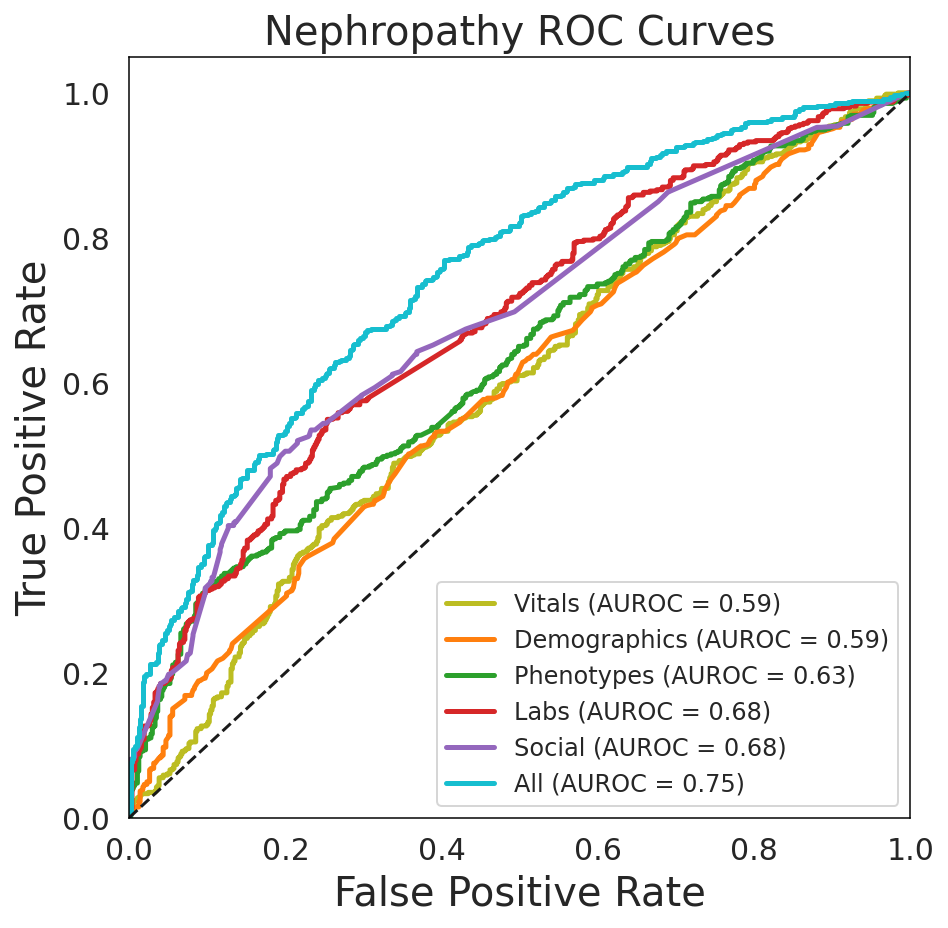

<Figure size 504x504 with 0 Axes>

In [78]:
plt.rcParams['figure.figsize']=7,7
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.75
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=['#bcbd22', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf'])

plt.plot(fpr['Vitals']['RF'], tpr['Vitals']['RF'],
         label='Vitals (AUROC = {0:0.2f})'
               ''.format(auroc['Vitals']['RF']),
         linewidth=2.5)

plt.plot(fpr['Demos']['AdaBoost'], tpr['Demos']['AdaBoost'],
         label='Demographics (AUROC = {0:0.2f})'
               ''.format(auroc['Demos']['AdaBoost']),
         linewidth=2.5)

plt.plot(fpr['Codes']['ET'], tpr['Codes']['ET'],
         label='Phenotypes (AUROC = {0:0.2f})'
               ''.format(auroc['Codes']['ET']),
         linewidth=2.5)

plt.plot(fpr['Labs']['RF'], tpr['Labs']['RF'],
         label='Labs (AUROC = {0:0.2f})'
               ''.format(auroc['Labs']['RF']),
         linewidth=2.5)

plt.plot(fpr['Social']['ET'], tpr['Social']['ET'],
         label='Social (AUROC = {0:0.2f})'
               ''.format(auroc['Social']['ET']),
         linewidth=2.5)

plt.plot(fpr['All']['RF'], tpr['All']['RF'],
         label='All (AUROC = {0:0.2f})'
               ''.format(auroc['All']['RF']),
         linewidth=2.5)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20, fontweight=100)
plt.ylabel('True Positive Rate', fontsize=20, fontweight=100)
plt.title('Nephropathy ROC Curves', fontsize=20, fontweight=100)
plt.legend(loc="lower right",fontsize=12)
plt.grid(False)
plt.savefig(r'./figures/renalphen_AUROC.svg', format='svg')
plt.figure()

### 10. Make calibration plot

In [31]:
Xtrain, Xtest, ytrain, ytest = train_test_split(input_dict['All'], renal_final_clf, random_state=42, test_size=0.2) 

In [33]:
model=renal_all_model_dict['All']['RF']
print(model)

RandomForestClassifier(bootstrap=False, max_depth=95.0, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=2000)


AUROC: 0.74650551994302
Brier Score: 0.20903597041032276


<Figure size 504x504 with 0 Axes>

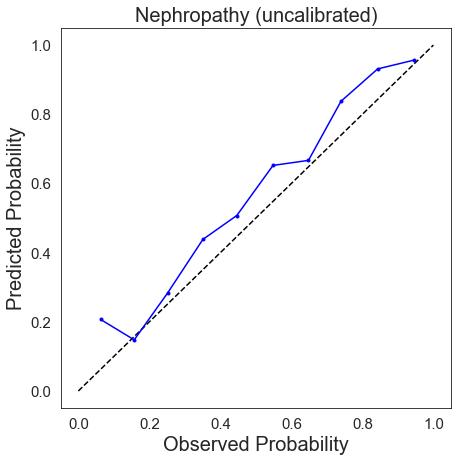

<Figure size 504x504 with 0 Axes>

In [34]:
plt.rcParams['figure.figsize']=7,7
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.75

probs = model.predict_proba(Xtest)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(ytest, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--', color="black")
# plot model reliability
plt.plot(mpv, fop, marker='.', color="blue")

ypred = model.predict(Xtest)
probs = model.predict_proba(Xtest)
pos_probs = probs[:, 1]
rocauc = roc_auc_score(ytest, pos_probs)
print('AUROC:', rocauc)
bs=brier_score_loss(ytest, pos_probs)
print('Brier Score:', bs)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Observed Probability', fontsize=20, fontweight=100)
plt.ylabel('Predicted Probability', fontsize=20, fontweight=100)
plt.title('Nephropathy (uncalibrated)', fontsize=20, fontweight=100)
plt.grid(False)
plt.figure()

AUCROC: 0.7475166615791615
Brier Score: 0.20403856881000923


<Figure size 504x504 with 0 Axes>

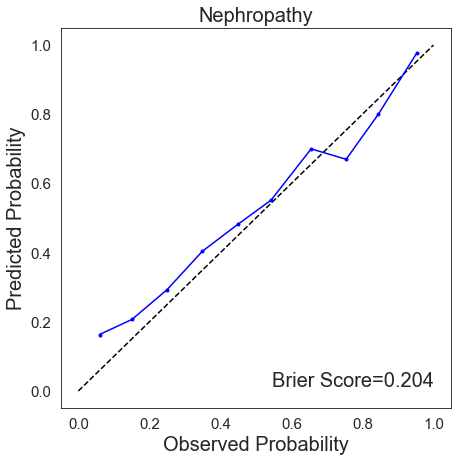

<Figure size 504x504 with 0 Axes>

In [44]:
plt.rcParams['figure.figsize']=7,7
plt.rcParams['axes.facecolor']='white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 0.75

from sklearn.calibration import CalibratedClassifierCV
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=5)
calibrated.fit(Xtrain, ytrain)
# predict probabilities
probs = calibrated.predict_proba(Xtest)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(ytest, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--',color="black")
# plot calibrated reliability
plt.plot(mpv, fop, marker='.',color="blue")

ypred = calibrated.predict(Xtest)
probs = calibrated.predict_proba(Xtest)
pos_probs = probs[:, 1]
rocauc = roc_auc_score(ytest, pos_probs)
print('AUCROC:', rocauc)
bs=brier_score_loss(ytest, pos_probs)
print('Brier Score:', bs)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Observed Probability', fontsize=20, fontweight=100)
plt.ylabel('Predicted Probability', fontsize=20, fontweight=100)
plt.title('Nephropathy', fontsize=20, fontweight=100)
plt.grid(False)
matplotlib.pyplot.text(1,0,'Brier Score=0.204', horizontalalignment='right',
     verticalalignment='bottom',fontsize=20)
plt.savefig(r'./figures/renal_calib_plot.svg', format='svg')
plt.figure()

### 11. encounters between T2DM dx and comp

In [29]:
renal_final_clf.to_excel('renal_out.xlsx')

In [4]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/init_comps_dict.pkl', 'rb') as handle:
    init_comps_dict = pickle.load(handle)

In [5]:
# creating new dataframe from the above dictionary for time of first complication with the patient number as the index
comps_time_df = pd.DataFrame.from_dict(init_comps_dict, orient='index')
comps_time_df = comps_time_df.apply(pd.to_datetime, errors='coerce')

# sort table by patient number (index)
comps_time_df.sort_index(inplace=True)

In [6]:
comps_time_df.drop(['initial_OPTH','initial_CVD','initial_NEUROPATH'],axis=1,inplace=True)

In [21]:
time_to_renal=renal_final.to_frame('time_to_renal(yr)')

In [22]:
merge = comps_time_df.merge(time_to_renal, left_index=True, right_index=True)

In [23]:
encounters = pd.read_csv(r'/Users/amomenzadeh/Desktop/DM_csv/renal_encounters.csv',low_memory=False)

In [24]:
encounters.drop(['department_name', 'department_id', 'department_external_name',
       'department_specialty', 'payor_type_primary_c','age_at_visit_years',
       'payor_type_primary_name', 'payer_type_secondary_c','visit_type_id',
       'payer_type_secondary_name', 'appt_status_c', 'appt_status_name','discharge_status_c', 'discharge_status_name',
       'length_of_stay_days', 'hosp_serv_c', 'hosp_serv_name','visit_type_name',
       'adm_for_surg_yn', 'surgical_svc_c', 'surgical_svc_name', 'drg','visit_date_shifted',
       'drg_type', 'drg_name', 'visit_provider_id', 'visit_provider_name','admit_date_shifted',
       'visit_provider_title', 'visit_provider_npi', 'admission_provider_id',
       'admission_provider_name', 'admission_provider_title','admit_source_c','admit_source_name','discharge_date_shifted',
       'admission_provider_npi', 'sourcesystem_cd','encounter_num','enc_type','src_enc_type_c'],inplace=True, axis=1)

In [25]:
encounters.i2b2_date_shifted = pd.to_datetime(encounters.i2b2_date_shifted, format = '%Y-%m-%d') # converted dx date column to datetime

In [31]:
encounters=encounters.sort_values(by='i2b2_date_shifted')

In [26]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/renal_enc.pkl', 'wb') as handle:
    pickle.dump(encounters, handle)

In [27]:
visits=[]
for x in merge.index:
    enc=encounters[(encounters.patient_num==x)]
    after_DM=enc[(enc.i2b2_date_shifted.values >= merge.loc[[x]].initial_DIAB.values)]
    before_comp=after_DM[(after_DM.i2b2_date_shifted.values <= merge.loc[[x]].initial_KIDNEY.values)]
    visits.append(len(before_comp.i2b2_date_shifted.unique()))

In [28]:
merge['visits_bw']=visits

In [29]:
merge['visits_bw/yr']=merge['visits_bw']/merge['time_to_renal(yr)']

In [30]:
merge['output_class']=renal_final_clf

In [31]:
with open(r'/Users/amomenzadeh/Desktop/DM_pickles/renal_merge.pkl', 'wb') as handle:
    pickle.dump(merge, handle)

In [32]:
fast=merge[merge['output_class']==1]

In [33]:
slow=merge[merge['output_class']==0]

In [34]:
fast.describe()

,time_to_renal(yr),visits_bw,visits_bw/yr,output_class
count,2805.000000,2805.000000,2805.000000,2805.0
mean,1.271791,38.228164,43.025790,1.0
std,0.891887,43.427083,46.135914,0.0
min,0.084875,2.000000,0.653386,1.0
25%,0.451755,9.000000,12.137968,1.0
50%,1.138969,23.000000,28.363518,1.0
75%,2.015100,50.000000,56.191154,1.0
max,3.066456,335.000000,375.984926,1.0


In [35]:
slow.describe()

,time_to_renal(yr),visits_bw,visits_bw/yr,output_class
count,2803.000000,2803.000000,2803.000000,2803.0
mean,6.358120,106.970746,17.552275,0.0
std,2.530855,115.485228,17.687748,0.0
min,3.069194,0.000000,0.000000,0.0
25%,4.283456,21.000000,3.630643,0.0
50%,5.796149,71.000000,12.729631,0.0
75%,7.844104,149.000000,25.670751,0.0
max,15.480126,902.000000,154.065927,0.0


In [36]:
fast=merge[merge['output_class']==1]

In [37]:
merge.loc[merge['output_class']==1 ,'output_class']='Fast'
merge.loc[merge['output_class']==0 ,'output_class']='Slow'

Slow v.s. Fast: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.461e-153 U_stat=2.331e+06


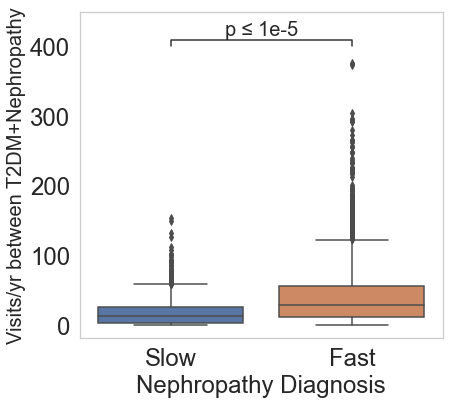

In [39]:
sns.set(style="whitegrid")

x = "output_class"
y = "visits_bw/yr"
order = ['Slow','Fast']
ax = sns.boxplot(data=merge, x=x, y=y, order=order)
add_stat_annotation(ax, data=merge, x=x, y=y, order=order,
                    box_pairs=[('Slow','Fast')], 
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2,fontsize=20)
_ = ax.set(xlabel="Nephropathy Diagnosis", ylabel="Visits between T2DM and Nephropathy Diagnoses")

ax.tick_params(labelsize=24)
ax.set_xlabel("Nephropathy Diagnosis",fontsize=24)
ax.set_ylabel("Visits/yr between T2DM+Nephropathy",fontsize=20)
sns.set(rc={'figure.figsize':(6.5,6)})
ax.grid(False)
plt.savefig(r'/Users/amomenzadeh/Desktop/DM_figures/renal_visits.svg', format='svg',bbox_inches='tight')
plt.show()